In [1]:
%matplotlib widget
import pylab as plt
import numpy as np
from astropy.io import fits
from glob import glob
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import HuberRegressor
from sklearn.impute import SimpleImputer
from joblib import dump,load

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.impute import SimpleImputer

import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.neighbors import LocalOutlierFactor


# Definitions

In [2]:
def poly_continuum(y,x):
    #note the change in argument order in this version
    # this fits a poly to the continuum

    # assumes wavelength array is in nm
    # and that fluctuations are in 10nm scale
    order = int((x[-1]-x[0])/(10))

    try:
        # standardize    
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        x_train = x_scaler.fit_transform(x[..., None])
        y_train = y_scaler.fit_transform(y[..., None])

        # fit model
        model = Pipeline([('poly', PolynomialFeatures(degree=order)),
                  ('linear', HuberRegressor())])

        model.fit(x_train, y_train.ravel())

        # do some predictions
        test_x = x

        test_x_transformed = x_scaler.transform(test_x[..., None])
        y_transformed = model.predict(test_x_transformed)
        predictions = y_scaler.inverse_transform(y_transformed[..., None])

        return(predictions.ravel())
    except ValueError as e:
        print(e)
        print('couldn\'t fit continuum this time! probably too flat already...')
        return(np.ones_like(y))

def Huber_continuum(y,x):
    #note the change in arguments order in this version
    try:
        # standardize    
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        x_train = x_scaler.fit_transform(x[..., None])
        y_train = y_scaler.fit_transform(y[..., None])

        # fit model
        model = HuberRegressor(epsilon=1)
        model.fit(x_train, y_train.ravel())

        # do some predictions
        test_x = x
        
        test_x_transformed = x_scaler.transform(test_x[..., None])
        y_transformed = model.predict(test_x_transformed)
        predictions = y_scaler.inverse_transform(y_transformed[..., None])

        return(predictions.ravel())
    except ValueError as e:
        print(e)
        print('couldn\'t fit continuum this time! probably too flat already...')
        return(np.ones_like(y))
    
class NormalizeSpectra(BaseEstimator, TransformerMixin):

    def __init__(self,continuum_type=Huber_continuum):
        self.continuum_type=continuum_type
        

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values
        
        # note that first row of X contains wavelengths, the rest have fluxes
        continua = np.apply_along_axis(self.continuum_type,1,X[1:,:],X[0,:])
        
        # here we need to return an array with wl in the first row
        self.continuum_fitted_ = np.append(X[0,:][None,...],continua,axis=0)
        
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        # Since 1st row is wl we skip it
        normalized_fluxes =  X[1:,:] / self.continuum_fitted_[1:,:]
        
        # we return an array with wl in 1st row, as it was fed.
        return np.append(X[0,:][None,...],normalized_fluxes,axis=0) 

def idx_flux(i):
    return 1+i
def idx_err(i):
    return 1+i+n_train

class CleanData(BaseEstimator, TransformerMixin):
    def __init__(self,imputer=SimpleImputer):
        self.imputer=imputer

    def fit(self,X,y=None):       
        # I won't do anything here as I'll let the real imputer do the checks
        return self  # always return self!
    
    def transform(self, X):

        # Skip wl row and transpose flux matrix
        XT = X[1:,:].T
        imputer = SimpleImputer()
        XT_transformed = imputer.fit_transform(XT)
        
        return np.append(X[0,:][None,...],XT_transformed.T,axis=0) 
    
class OffsetData(BaseEstimator, TransformerMixin):
    def __init__(self,offset=100):
        self.offset=offset

    def fit(self,X,y=None):       
        # I won't do anything here as I'll let the real imputer do the checks
        return self  # always return self!
    
    def transform(self, X):
        _ = X[1:,:]+self.offset
        # Skip wl row and transpose flux matrix
        # return X[1:,:] 
        return np.append(X[0,:][None,...],_,axis=0) 
    
class ErrNormalizeSpectra(BaseEstimator, TransformerMixin):

    # def __init__(self,continuum_type=Huber_continuum):
    #     self.continuum_type=continuum_type

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values
        
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        n_train = int((X.shape[0]-1)/2)
        # Since 1st row is wl we skip it
        # divide normalised fluxes by normalised errors
        error_normalized_fluxes = X[1:n_train+1,:]/X[n_train+1:,:]
        
        # we return an array with wl in 1st row, as it was fed.
        # We also loose the error spectra
        return np.append(X[0,:][None,...],error_normalized_fluxes,axis=0) 
    
class StddevSky(BaseEstimator, TransformerMixin):

    def __init__(self,continuum_type=Huber_continuum,sky_pixel_scale_factor = 1.05):
        self.continuum_type=continuum_type
        self.sky_pixel_scale_factor = sky_pixel_scale_factor

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values

        # calculate stddev of sky spectra normalised by noise array	
        self.stddev_ = np.std(X[1:,:],axis=0)+np.mean(X[1:,:],axis=0)

        # we define the sky pixels as the pixes above
        # the threshold given by sky_pixles
        self.stddev_continuum_ = Huber_continuum(self.stddev_,X[0,:])
        
        self.sky_pixels_ = self.stddev_>=self.stddev_continuum_*self.sky_pixel_scale_factor

        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # now we have after all normalised fluxes the stddev flux,
        # it's continuum, and the sky pixel mask.
        # I'm not sure if this is the best way to carry over this info
        # so I need to come back to this later... 
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return np.vstack([X[0,:][None,...],X[1:,:],self.stddev_,self.stddev_continuum_,self.sky_pixels_]) 
    
class RemoveOutliersAfter(BaseEstimator, TransformerMixin):

    def __init__(self,n_neighbors=20,contamination='auto'):
        self.n_neighbors = n_neighbors
        self.contamination = contamination

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values

        self.X_ = X[1:-3,:] #take only fluxes
        self.sky_pixels_ = X[-1,:]==1 #sky pixels
        clf = LocalOutlierFactor(n_neighbors=self.n_neighbors,contamination=self.contamination)
        y_pred = clf.fit_predict(self.X_[:,self.sky_pixels_]) #run outlier detection only on sky pixels
        self.outleirs_ = y_pred==-1 #mask with outliers

        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Note that we return an array like X without the outliers
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        return np.vstack([X[0,:][None,...],self.X_[~self.outleirs_],X[-3:,:]])
    
class RemoveOutliersBefore(BaseEstimator, TransformerMixin):

    def __init__(self,n_neighbors=20,contamination='auto'):
        self.n_neighbors = n_neighbors
        self.contamination = contamination

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values

        self.X_ = X[1:,:] #take only fluxes
        clf = LocalOutlierFactor(n_neighbors=self.n_neighbors,contamination=self.contamination)
        y_pred = clf.fit_predict(self.X_) #run outlier detection only on sky pixels
        self.outleirs_ = y_pred==-1 #mask with outliers

        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Note that we return an array like X without the outliers
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        return np.vstack([X[0,:][None,...],self.X_[~self.outleirs_]])

# Load data

In [3]:
# idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/sky_res/'
idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/sky_res/'

# read all sky spectra
files = glob(idir+'sky*.fits')

# to do: try to implement a proper sklearn pipeline for this
# (i.e. replace nans, create errors if not provided, etc)

for i,file in enumerate(files):	
	hdu = fits.open(file)

	# I would have tried to use the pipeline error spectra but the are very 
	# funky (values close to 0 and also many negatives). For the rest of 
	# the tests I'm using the sqrt of the flux as the uncertainty
	# hdu_e = fits.open(file.replace('sky.','err.'))

	# wavelenght0
	ext=0 
	crval = hdu[ext].header['crval1']
	cdelt = hdu[ext].header['cdelt1']
	naxis = hdu[ext].header['naxis1']
	
	wl = crval+cdelt*np.arange(naxis)
	flux = hdu[ext].data +100 #I'm offsetting the flux by 100 to try something out (avoid dealing with negavites)

	if i == 0:
		#create array in first iteration 
		flux_array = np.empty(shape=(len(files),len(wl)))
	flux_array[i,:] = flux


In [4]:
# here we split data in a training set and a test set
flux_train_set,flux_test_set = train_test_split(flux_array,test_size=0.2,random_state=42)
n_train = len(flux_train_set)
n_test = len(flux_test_set)

# if we were to have a propper error specs from pipeline
# we should do the same to them here. But for now I'll 
# just use the sqrt of flux array

err_array = np.sqrt(np.abs(flux_array))
err_train_set,err_test_set = train_test_split(err_array,test_size=0.2,random_state=42)

print('spec. in training set: {:}'.format(len(flux_train_set)))
print('spec. in test set: {:}'.format(len(flux_test_set)))

# we put fluxes adn wl in a single array where the
# first row contains wavelengths

X_train = np.append(flux_train_set,err_train_set,axis=0)
X_test = np.append(flux_test_set,err_test_set,axis=0)

X_train = np.append(wl[None,...],X_train,axis=0)
X_test = np.append(wl[None,...],X_test,axis=0)

print('\n!!!!!!!!!!!!!!!!!!!!!!!!!!!\nX_train shape:',X_train.shape)
print('\nNote that the first row of X contains wavelengths\nthen you have all the fluxes followed by errors\n')

spec. in training set: 261
spec. in test set: 66

!!!!!!!!!!!!!!!!!!!!!!!!!!!
X_train shape: (523, 10220)

Note that the first row of X contains wavelengths
then you have all the fluxes followed by errors



# Data Pipeline

In [36]:
#sky pixel detection params
sky_pixel_scale_factor = 1.03
#outliers params
n_neighbors = 20
contamination = 'auto'

data_pipeline = Pipeline([
    ('offset',OffsetData(offset=0)),
    ('cleaner',CleanData()),
    ('norm',NormalizeSpectra(continuum_type=poly_continuum)),
    ('errnorm',ErrNormalizeSpectra()),
    ('kickoutliers',RemoveOutliersBefore(n_neighbors=n_neighbors,contamination=contamination)),
    ('stddevsky',StddevSky(continuum_type=Huber_continuum,sky_pixel_scale_factor=sky_pixel_scale_factor))
])

data_pipeline

Pipeline(steps=[('offset', OffsetData(offset=0)), ('cleaner', CleanData()),
                ('norm',
                 NormalizeSpectra(continuum_type=<function poly_continuum at 0x107a02020>)),
                ('errnorm', ErrNormalizeSpectra()),
                ('kick_outliers', RemoveOutliersBefore()),
                ('stddev_sky', StddevSky(sky_pixel_scale_factor=1.03))])

In [37]:
# Like before the 1st row of this array has the wl.
# The following ones have the transformed sky spec.
# ready for the PCA analysis. Then we have the 
# stddev spec, it's continuum and the sky pixel mask.
# Mind these last three rows, don't include them in 
# the flux spec. for the PCA analysis!!!   

X_prepared = data_pipeline.fit_transform(X_train)

## Sky pixels figure

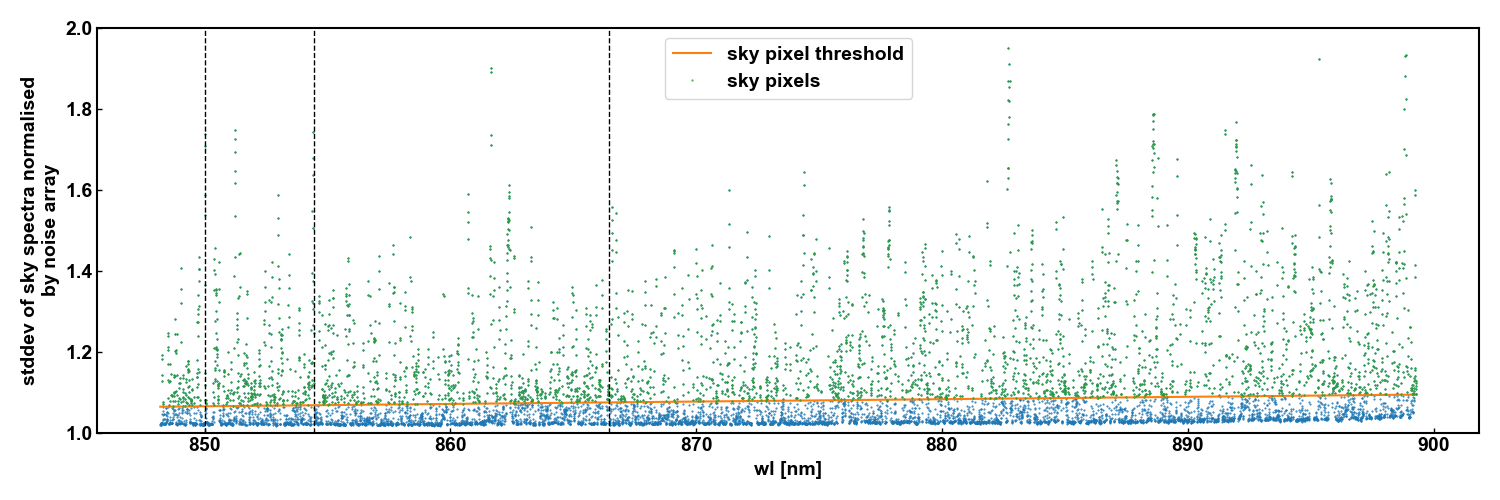

In [38]:
sky_pixels = X_prepared[-1,:]==1

f, ax = plt.subplots(figsize=(15,5))  
ax.plot(X_prepared[0,:],X_prepared[-3,:],'.',ms=1)
ax.plot(X_prepared[0,:],X_prepared[-2,:]*sky_pixel_scale_factor,label='sky pixel threshold')
ax.plot(X_prepared[0,:][sky_pixels],X_prepared[-3,:][sky_pixels],'.',ms=1,label='sky pixels')
ax.set_xlabel('wl [nm]')
ax.set_ylabel('stddev of sky spectra normalised\nby noise array')
# plt.semilogy()
ax.set_ylim(1,2)
plt.legend()
for _ in [850.04,854.44, 866.45]:
    ax.axvline(_,lw=1,ls='--',color='k')
plt.tight_layout()

# Train PCA

In [27]:
class MyPCA(BaseEstimator, TransformerMixin):

    def __init__(self,explained_variance = 0.95):
        self.explained_variance = explained_variance

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values

        sky_pixels = X[-1,:]==1 #pixel mask
        X_pca = X[1:-3,sky_pixels] #select only sky pixel flux

        print('training PCA...')
        # PCA run 
        pca = PCA()
        pca.fit(X_pca)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        d = np.argmax(cumsum>=self.explained_variance)+1
        
        print('{:} components explain {:}% of variance'.format(d,self.explained_variance*100))

        # re-train PCA
        pca = PCA(n_components=d)
        pca.fit(X_pca)

        # self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return pca  # always return self!
    
    #should I add a predict method here???

In [39]:
_pca = MyPCA()
pca = _pca.fit(X_prepared)

training PCA...
147 components explain 95.0% of variance


In [30]:
pca == _pca_

False

PCA(n_components=143)

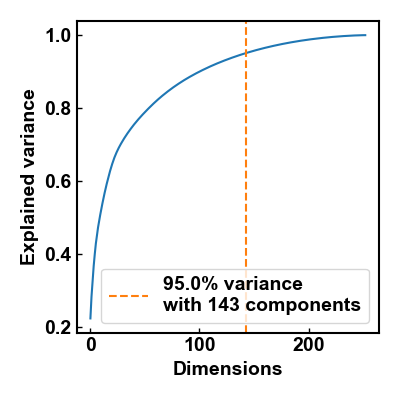

In [29]:
# PCA params
explained_variance = 0.95 

sky_pixels = X_prepared[-1,:]==1 #pixel mask
X_pca = X_prepared[1:-3,sky_pixels] #select only sky pixel flux

# PCA run 
pca = PCA()
pca.fit(X_pca)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=explained_variance)+1

f, ax = plt.subplots(figsize=(4,4))  
ax.plot(cumsum)
ax.axvline(d,ls='--',color='tab:orange',label='{:}% variance\nwith {:} components'.format(explained_variance*100,d))
ax.set_xlabel('Dimensions')
ax.set_ylabel('Explained variance')
plt.legend()
plt.tight_layout()

# re-train
pca = PCA(n_components=d)
pca.fit(X_pca)

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
PCA?

Init signature:
PCA(
    n_components=None,
    *,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    n_oversamples=10,
    power_iteration_normalizer='auto',
    random_state=None,
)
Docstring:     
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

Read more in the :ref:`User Guide <PCA>`.

Parameters
----------
n_components : int, float or 'mle', def

PCA(n_components=22)

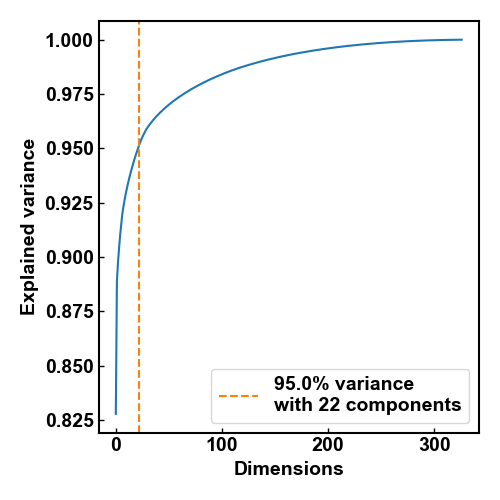

In [ ]:
# 1st pca run 
pca = PCA()
pca.fit(flux_array[:,sky_pixels])
cumsum = np.cumsum(pca.explained_variance_ratio_)
# explained_variance = 0.99
explained_variance = 0.95 # new test
d = np.argmax(cumsum>=explained_variance)+1

f, ax = plt.subplots(figsize=(5,5))  
ax.plot(cumsum)
ax.axvline(d,ls='--',color='tab:orange',label='{:}% variance\nwith {:} components'.format(explained_variance*100,d))
ax.set_xlabel('Dimensions')
ax.set_ylabel('Explained variance')
plt.legend()
plt.tight_layout()

#re train
pca = PCA(n_components=d)
pca.fit(flux_array[:,sky_pixels])

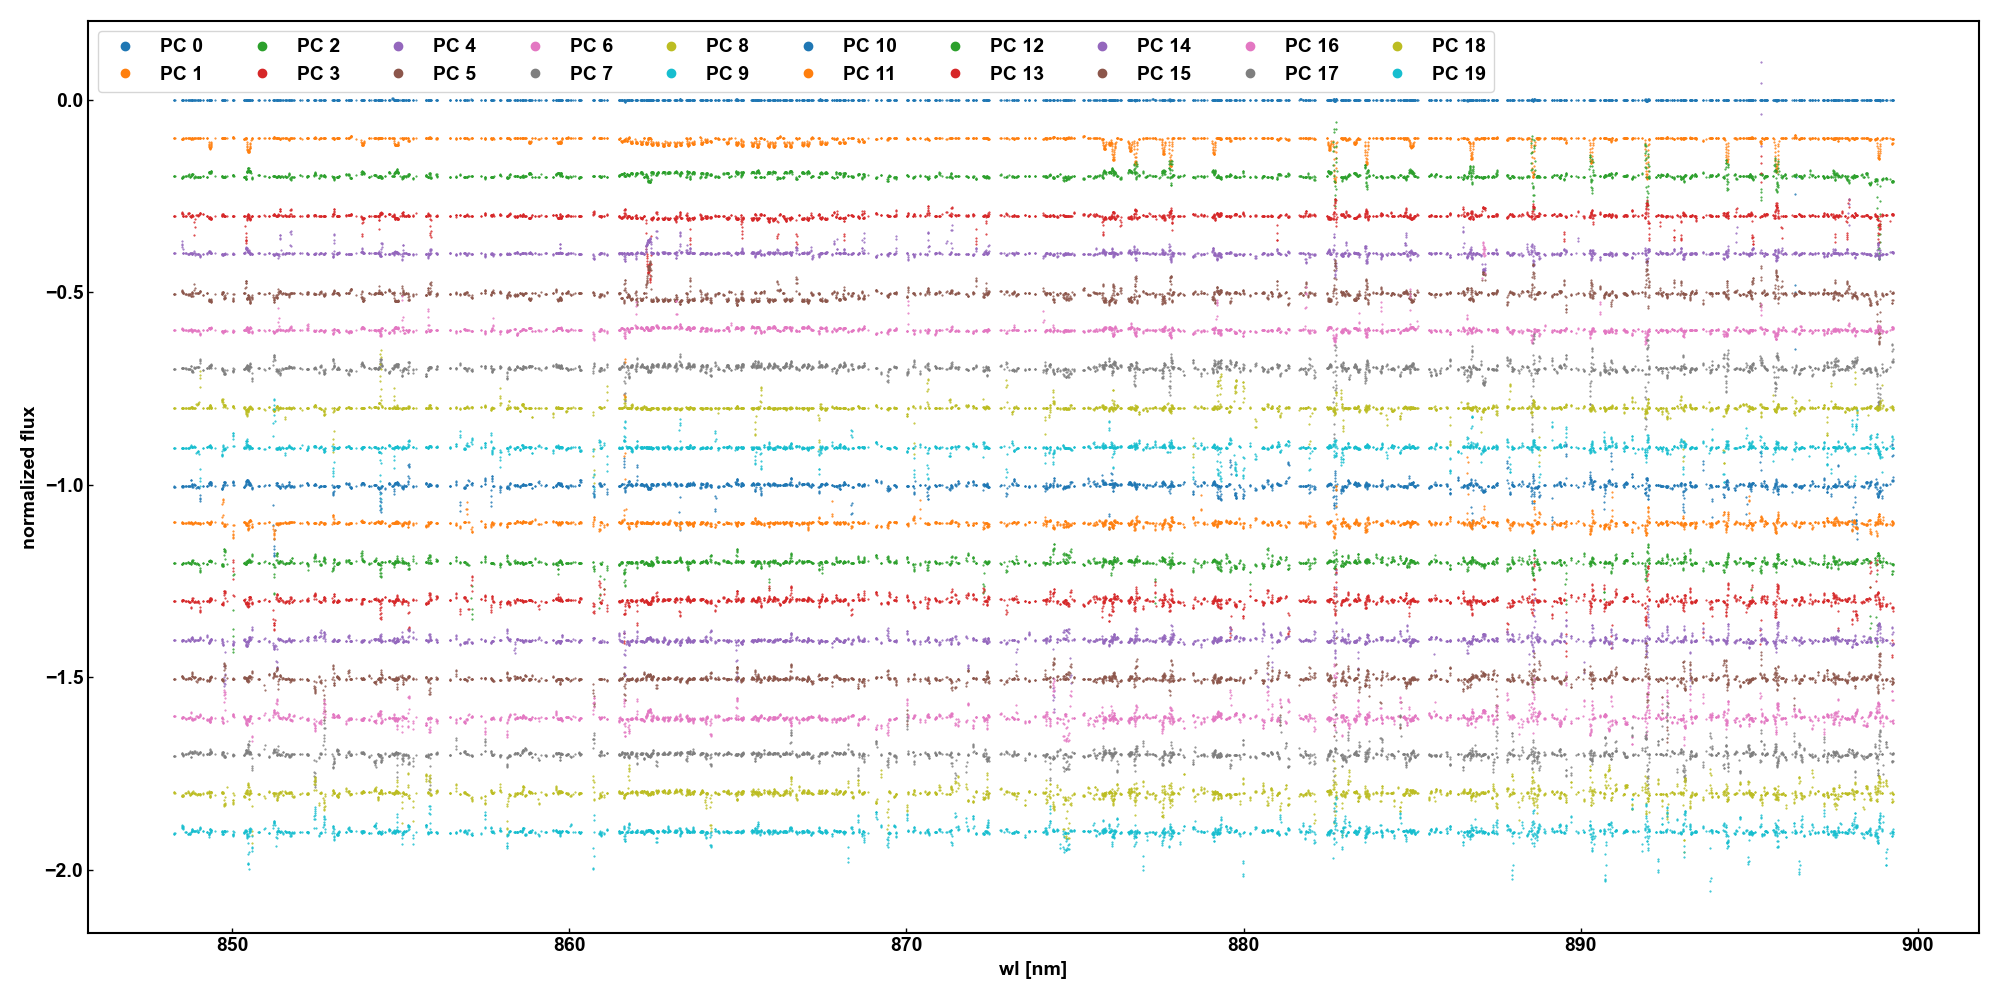

In [126]:
#plot first d-components
f, ax = plt.subplots(figsize=(20,10))

# for _ in range(d):
for _ in range(20):
    ax.plot(wl[sky_pixels],pca.components_[_]-(_*0.1),'.',ms=1,label='PC {:}'.format(_))
    ax.set_xlabel('wl [nm]')
    ax.set_ylabel('normalized flux')
    # plt.semilogy()
# plt.legend(markerscale=12,ncol=int(np.ceil(d/2)))
plt.legend(markerscale=12,ncol=int(np.ceil(20/2)))
plt.tight_layout()

In [14]:
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/Results/Config1/Epoch01/690286592_c1_e01_hor5_nosky.fits'
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config1/Epoch01/690286592_c1_e01_hor5.fits'
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config2/Epoch02/690006912_c2_e02_hor5.fits' #very high snr
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config1/Epoch06/690016128_c1_e06_hor5.fits'
spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config1/Epoch06/690050944_c1_e06_hor5.fits'

hdu = fits.open(spec_path)

ext=0 
crval = hdu[ext].header['crval1']
cdelt = hdu[ext].header['cdelt1']
naxis = hdu[ext].header['naxis1']

wl = crval+cdelt*np.arange(naxis)
flux = hdu[ext].data

# flux = flux/Huber_continuum(wl,flux)
flux = flux/poly_continuum(flux,wl)

plt.close('all')

In [42]:
weights = pca.transform(flux[sky_pixels][None,...])
model = pca.inverse_transform(weights)

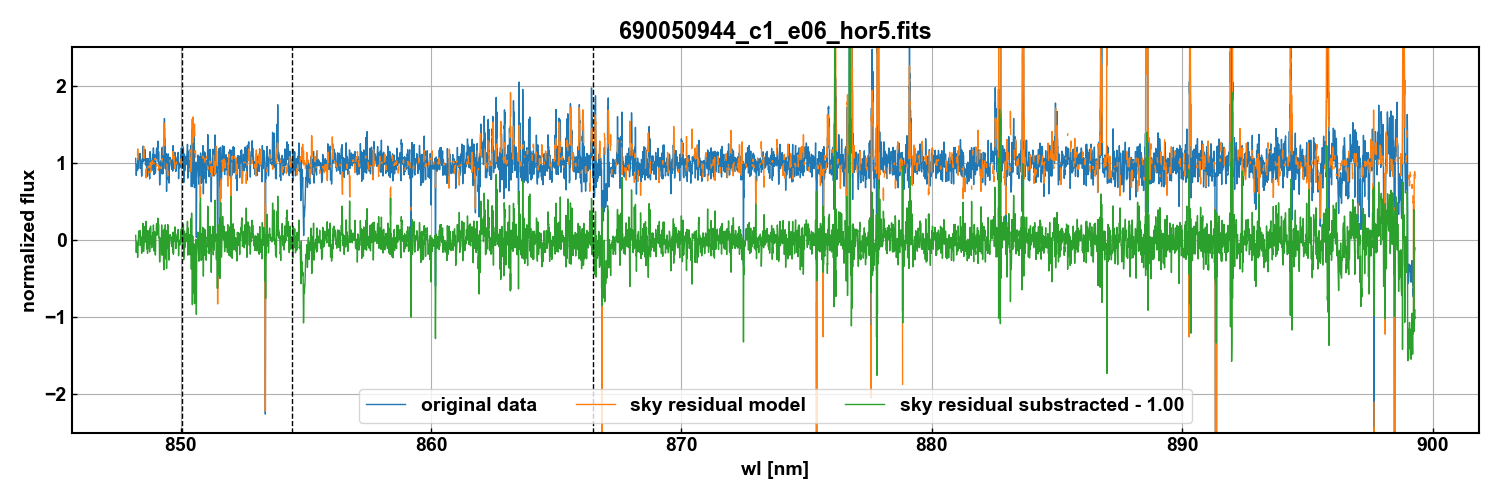

In [41]:
# centre the figure on the CaT
xlim_lo,xlim_hi = 849.1,870
ncol=3
offset = 1

plt.close('all')

f, ax = plt.subplots(figsize=(15,5))
plt.title(spec_path.split('/')[-1])
ax.plot(wl,flux,'-',lw=1,label='original data')
_model = np.ones_like(wl)*np.nan
_model[sky_pixels] = model[0,:]
ax.plot(wl,_model,'-',lw=1,label='sky residual model')
flux2 = flux.copy()
flux2[sky_pixels] = flux2[sky_pixels]-model[0,:]+1
ax.plot(wl,flux2-offset,ls='-',lw=1,label='sky residual substracted - {:.2f}'.format(offset))
for _ in [850.04,854.44, 866.45]:
    ax.axvline(_,lw=1,ls='--',color='k')
plt.legend(markerscale=12)
# ax.set_xlim(849,870)

#set automatic yscale
_flxs = np.r_[flux[(wl>=xlim_lo)&(wl<=xlim_hi)],
            flux2[(wl>=xlim_lo)&(wl<=xlim_hi)]-1,
            model[0][(wl[sky_pixels]>=xlim_lo)&(wl[sky_pixels]<=xlim_hi)]]

_flxs_min,_flxs_max = _flxs.min(),_flxs.max()

if _flxs_min<0:
    ax.set_ylim(1.1*_flxs_min,1.1*_flxs_max)
else:
    ax.set_ylim(0.9*_flxs_min,1.1*_flxs_max)

plt.legend(markerscale=12,ncol=ncol)
# ax.set_xlim(xlim_lo,xlim_hi)
ax.set_ylim(-offset*2.5,2.5*offset)
ax.set_xlabel('wl [nm]')
ax.set_ylabel('normalized flux')
plt.tight_layout()
plt.grid()

In [59]:
# save pca models for later use
# dump([sky_pixels,pca], 'sky_residual_pca_16-01-24.joblib')
dump([sky_pixels,pca], 'sky_residual_pca_18-01-24v2.joblib')

['sky_residual_pca_18-01-24v2.joblib']